# Staged Pass Manager

StagedPassManagers are a structure built on top of predefined stages of PassManagers the enable composing labeled stages of a pass manager pipeline

In [1]:
import pprint

import numpy as np

import qiskit
from qiskit.transpiler import StagedPassManager, PassManager
from qiskit.transpiler.passes import *
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.preset_passmanagers import common
from qiskit.circuit import QuantumCircuit

In [2]:
# Only available starting with Qiskit 0.21.0
print(qiskit.__version__)

0.21.0rc1.dev0+bfde086


In [3]:
default_staged_pm = StagedPassManager()

In [4]:
print(default_staged_pm.stages)

['init', 'layout', 'routing', 'translation', 'optimization', 'scheduling']


In [5]:
staged_pm = StagedPassManager(stages=['layout', 'translate'])

In [6]:
print(staged_pm.stages)

['layout', 'translate']


In [7]:
cmap = CouplingMap.from_heavy_hex(11)
layout_stage = PassManager([VF2Layout(cmap, call_limit=int(5e9))])
layout_stage += common.generate_embed_passmanager(cmap)

In [8]:
translation_stage = common.generate_translation_passmanager(None, ['u', 'cx'])

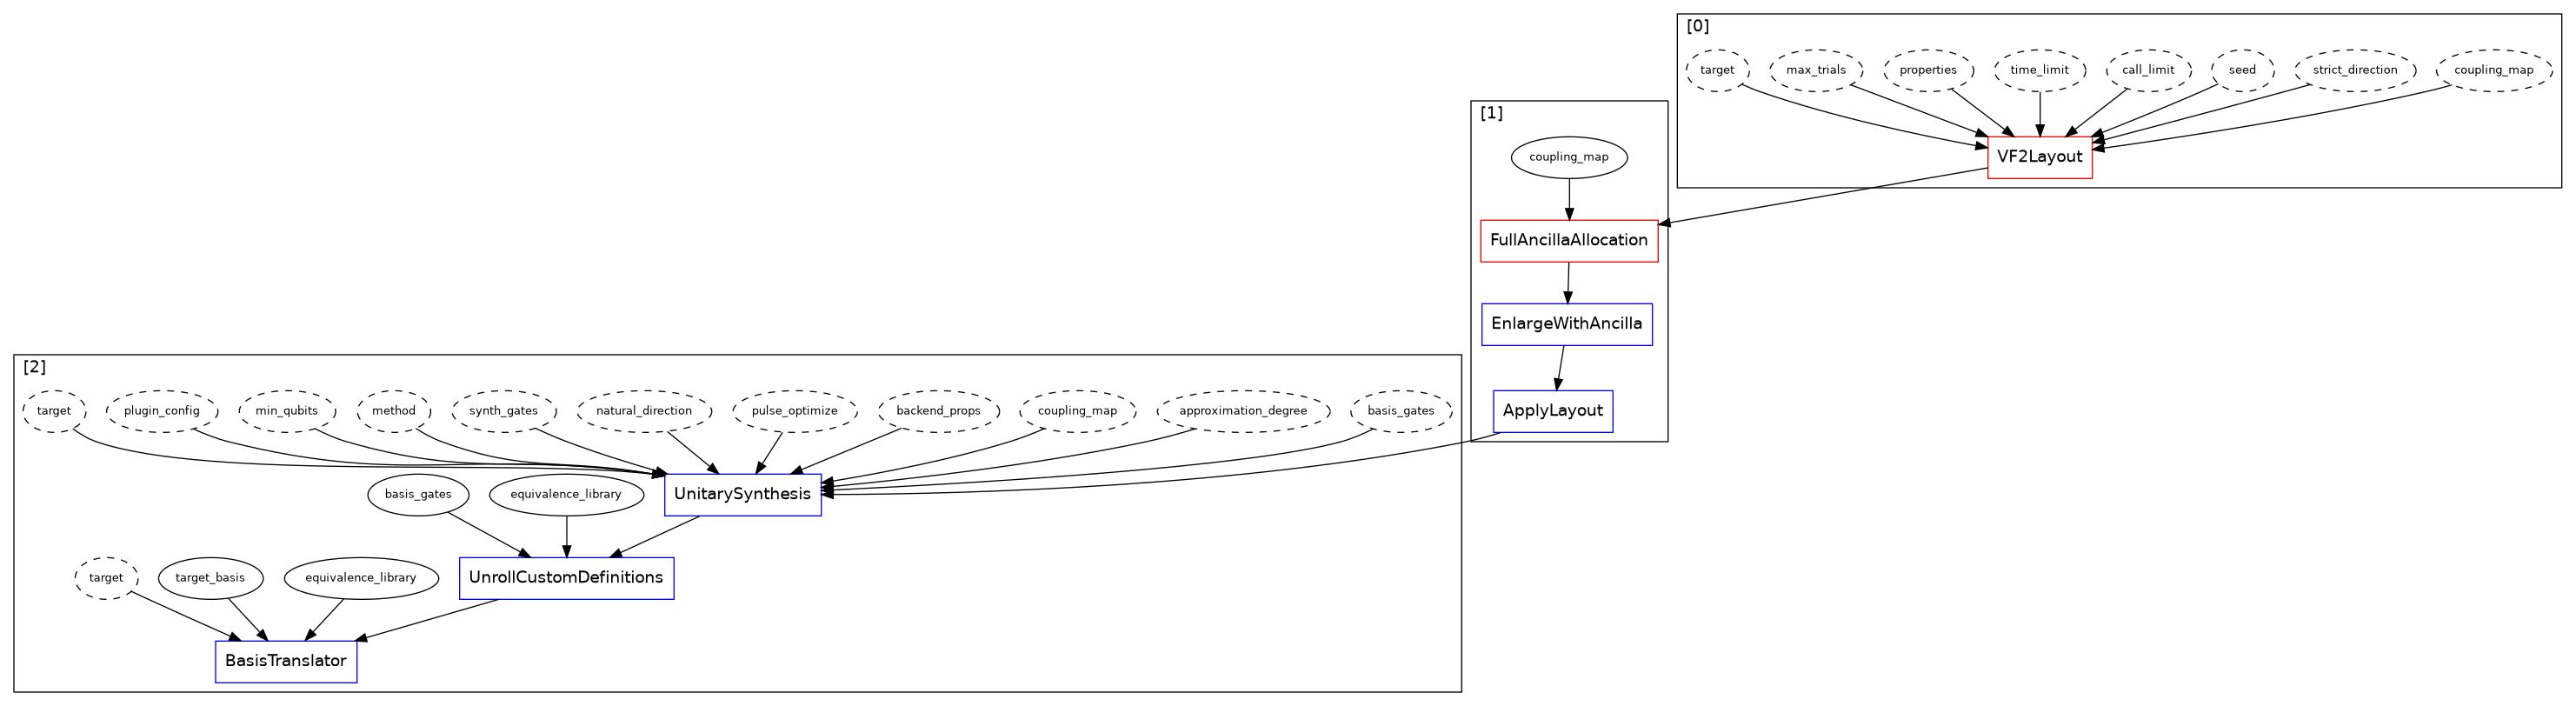

In [9]:
staged_pm = StagedPassManager(stages=['layout', 'translate'], layout=layout_stage)
staged_pm.translate = translation_stage
staged_pm.draw()

In [10]:
staged_pm.pre_layout = common.generate_unroll_3q(None, ['u', 'cx'])
staged_pm.post_layout = common.generate_pre_op_passmanager(coupling_map=cmap)
staged_pm.pre_translate = PassManager(Depth())

In [11]:
staged_pm.translate.append(Size())

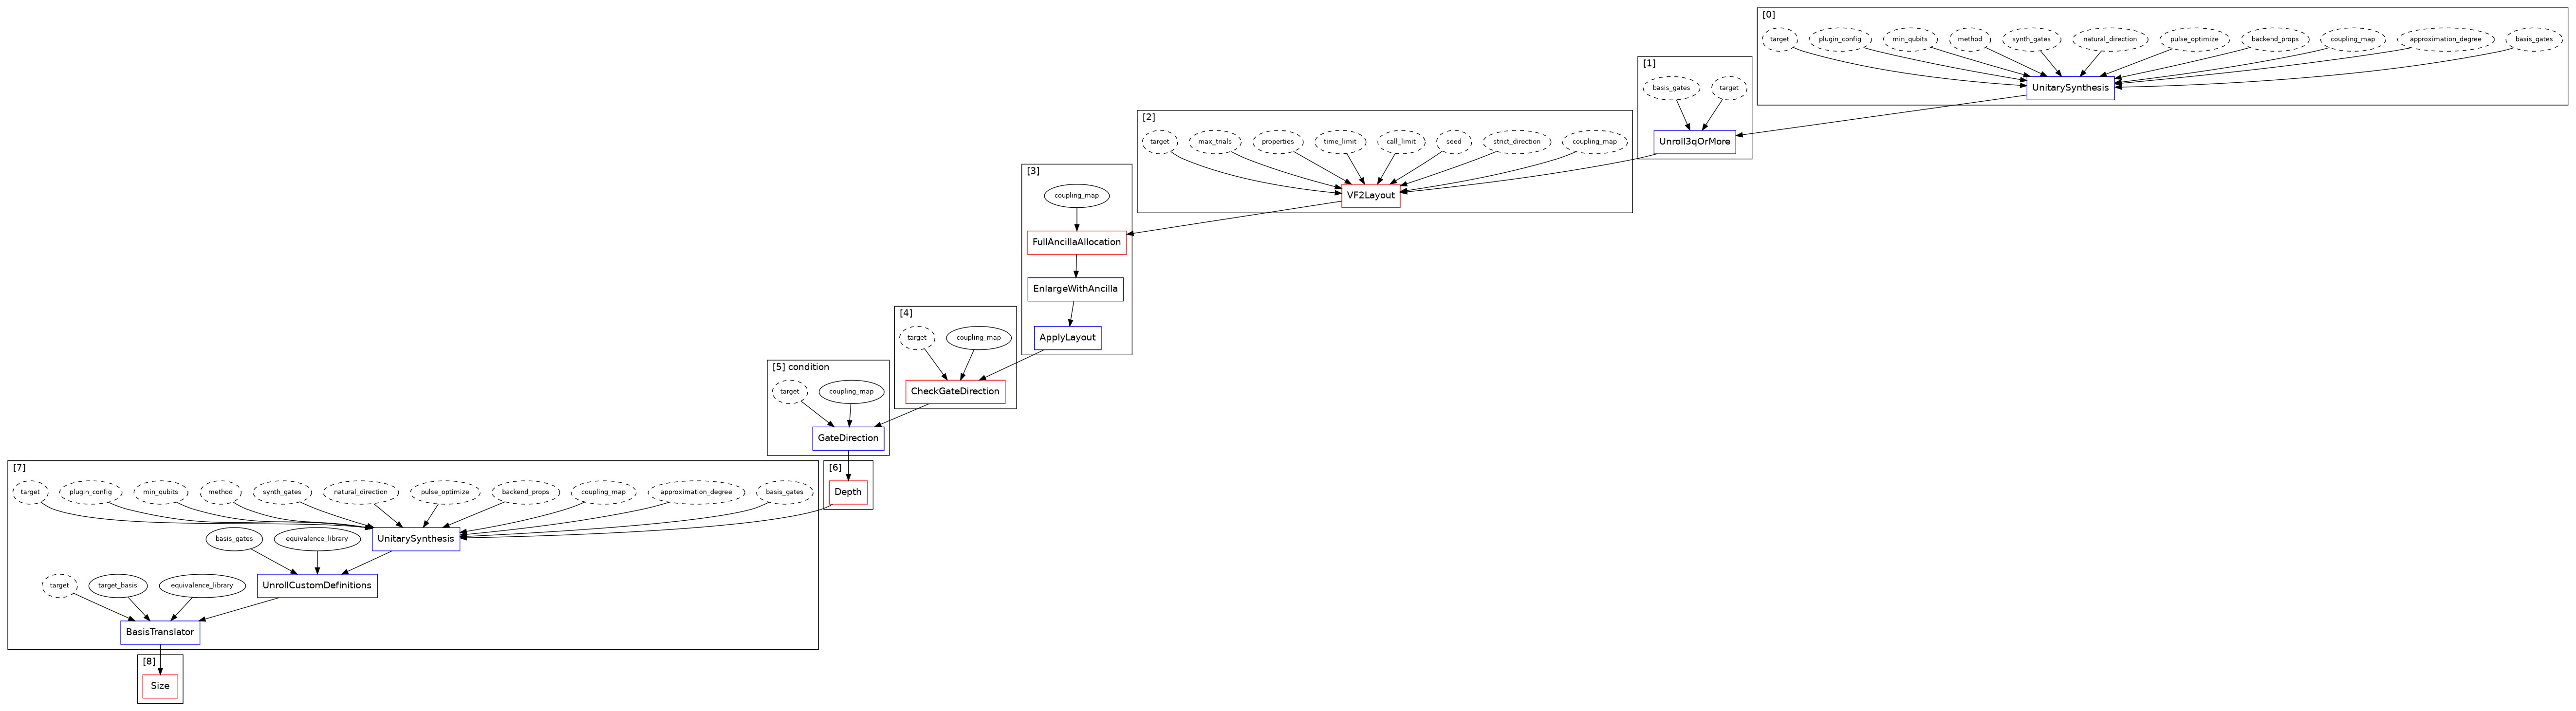

In [12]:
staged_pm.draw()

## Preset Pass Managers

Starting in 0.21 the preset passmanagers are now going to be StagedPassManagers This makes it easier to work with modifying or augmenting a typical `transpile()` pipeline with customizations or additional steps

In [13]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.providers.fake_provider import FakeGuadalupeV2
from qiskit.circuit.library import XGate, HGate, RXGate, PhaseGate, TGate, TdgGate

In [14]:
backend = FakeGuadalupeV2()
opt_level_1_pm = generate_preset_pass_manager(1, backend)

In [15]:
print(type(opt_level_1_pm))

<class 'qiskit.transpiler.passmanager.StagedPassManager'>


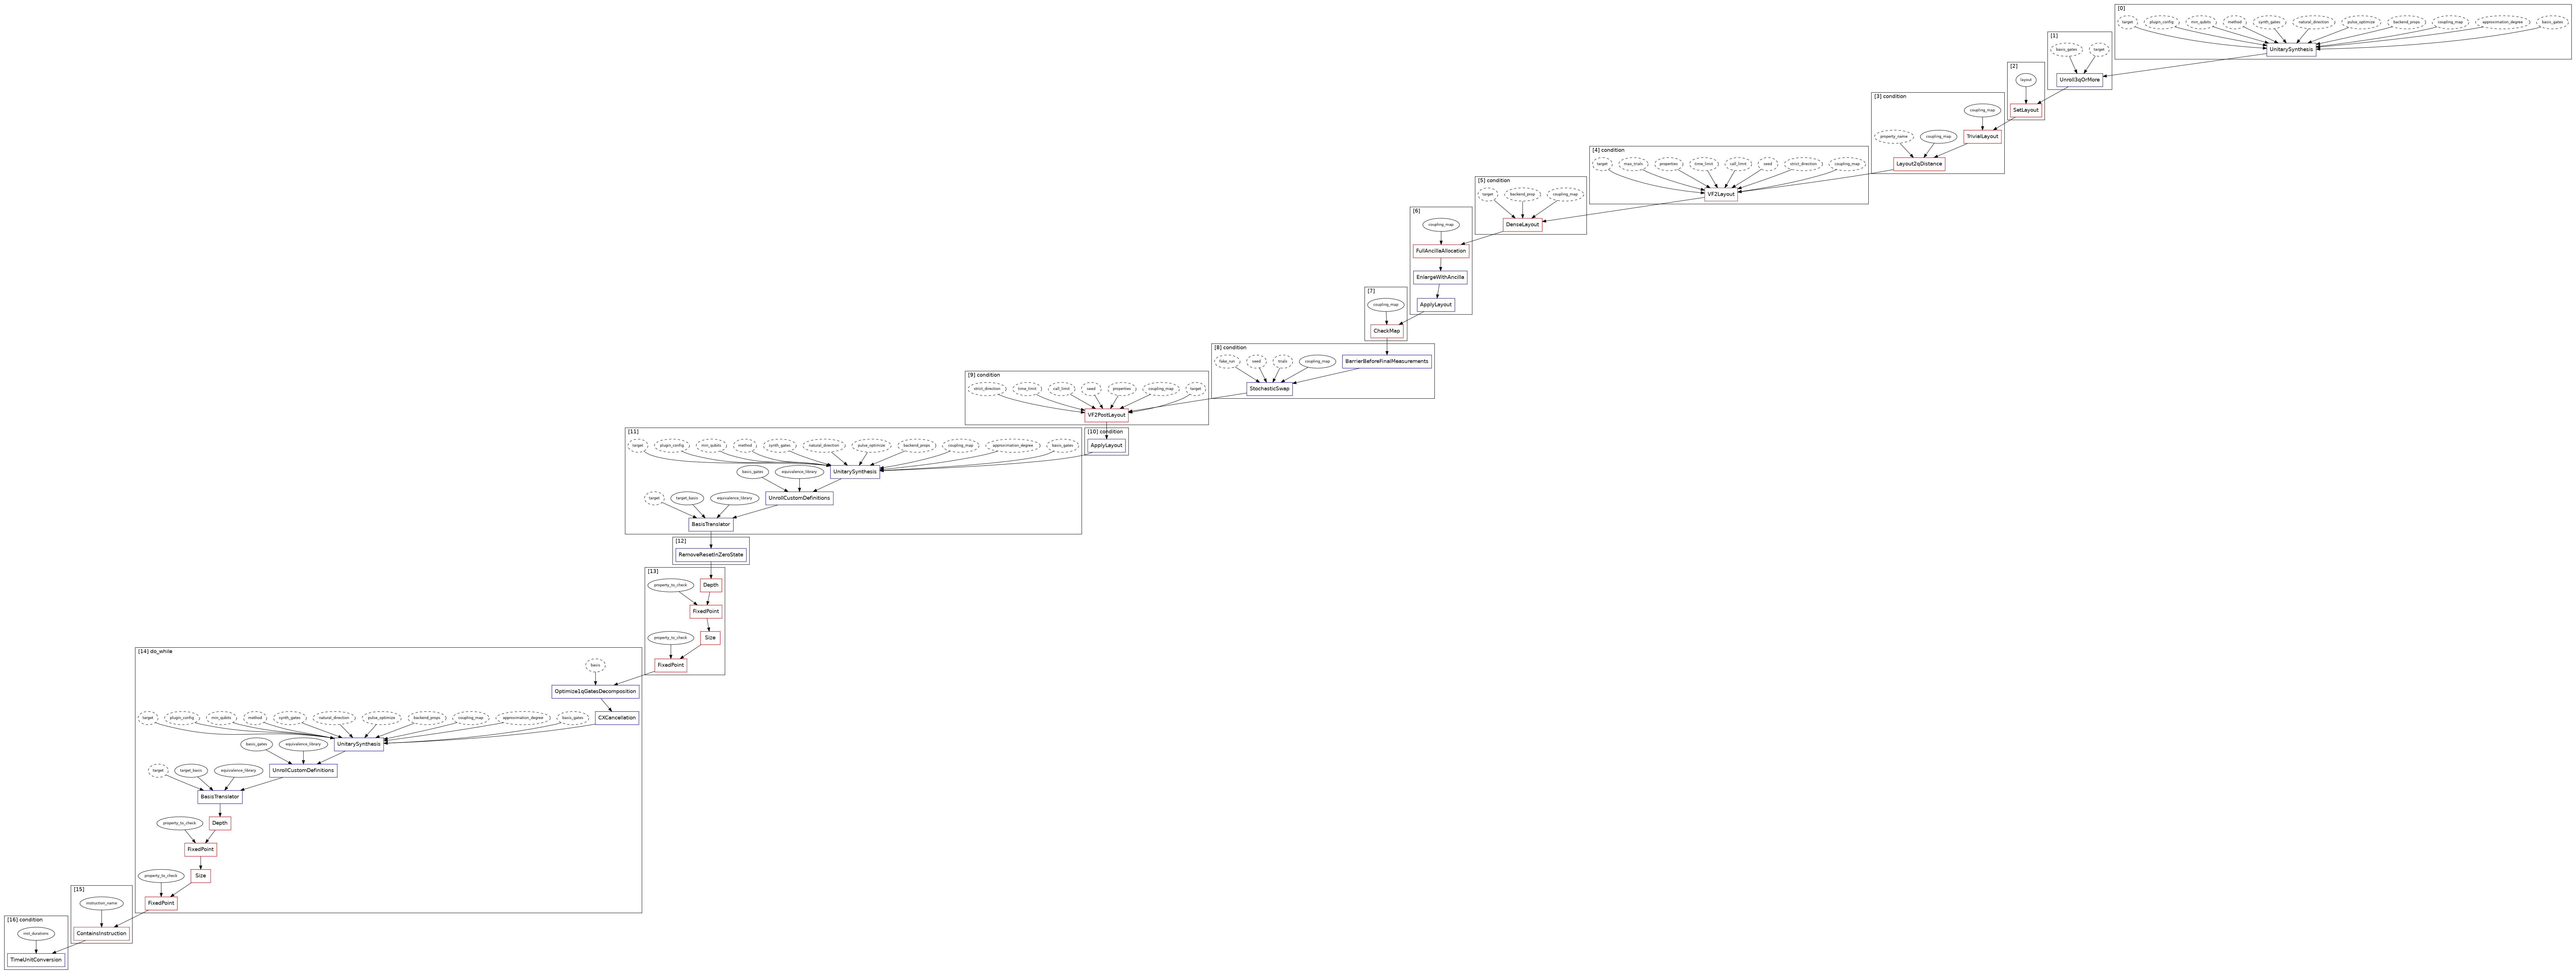

In [16]:
opt_level_1_pm.draw()

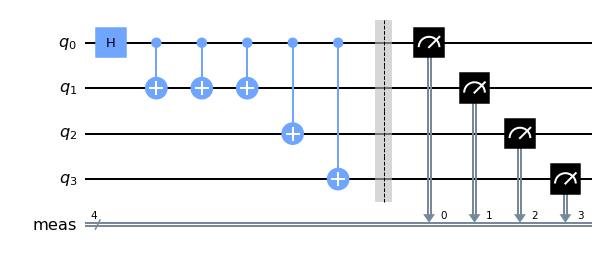

In [17]:
circuit = QuantumCircuit(4)
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(0, 1)
circuit.cx(0, 1)
circuit.cx(0, 2)
circuit.cx(0, 3)
circuit.measure_all()
circuit.draw('mpl')

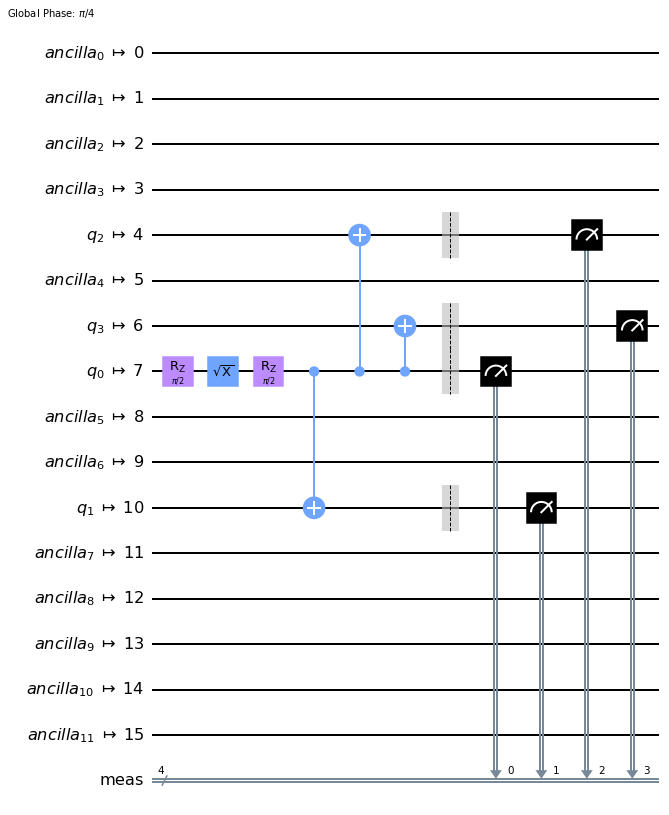

In [18]:
opt_level_1_pm.run(circuit).draw('mpl')

In [19]:
backend_durations = backend.target.durations()

dd_sequence = [XGate(), XGate()]

scheduling_pm = PassManager([
    ALAPScheduleAnalysis(backend_durations),
    PadDynamicalDecoupling(backend_durations, dd_sequence),
])

inverse_gate_list = [
    HGate(),
    (RXGate(np.pi / 4), RXGate(-np.pi / 4)),
    (PhaseGate(np.pi / 4), PhaseGate(-np.pi / 4)),
    (TGate(), TdgGate()),
]

logical_opt = PassManager([
    CXCancellation(),
    InverseCancellation([HGate(), (RXGate(np.pi / 4), RXGate(-np.pi / 4))])
])

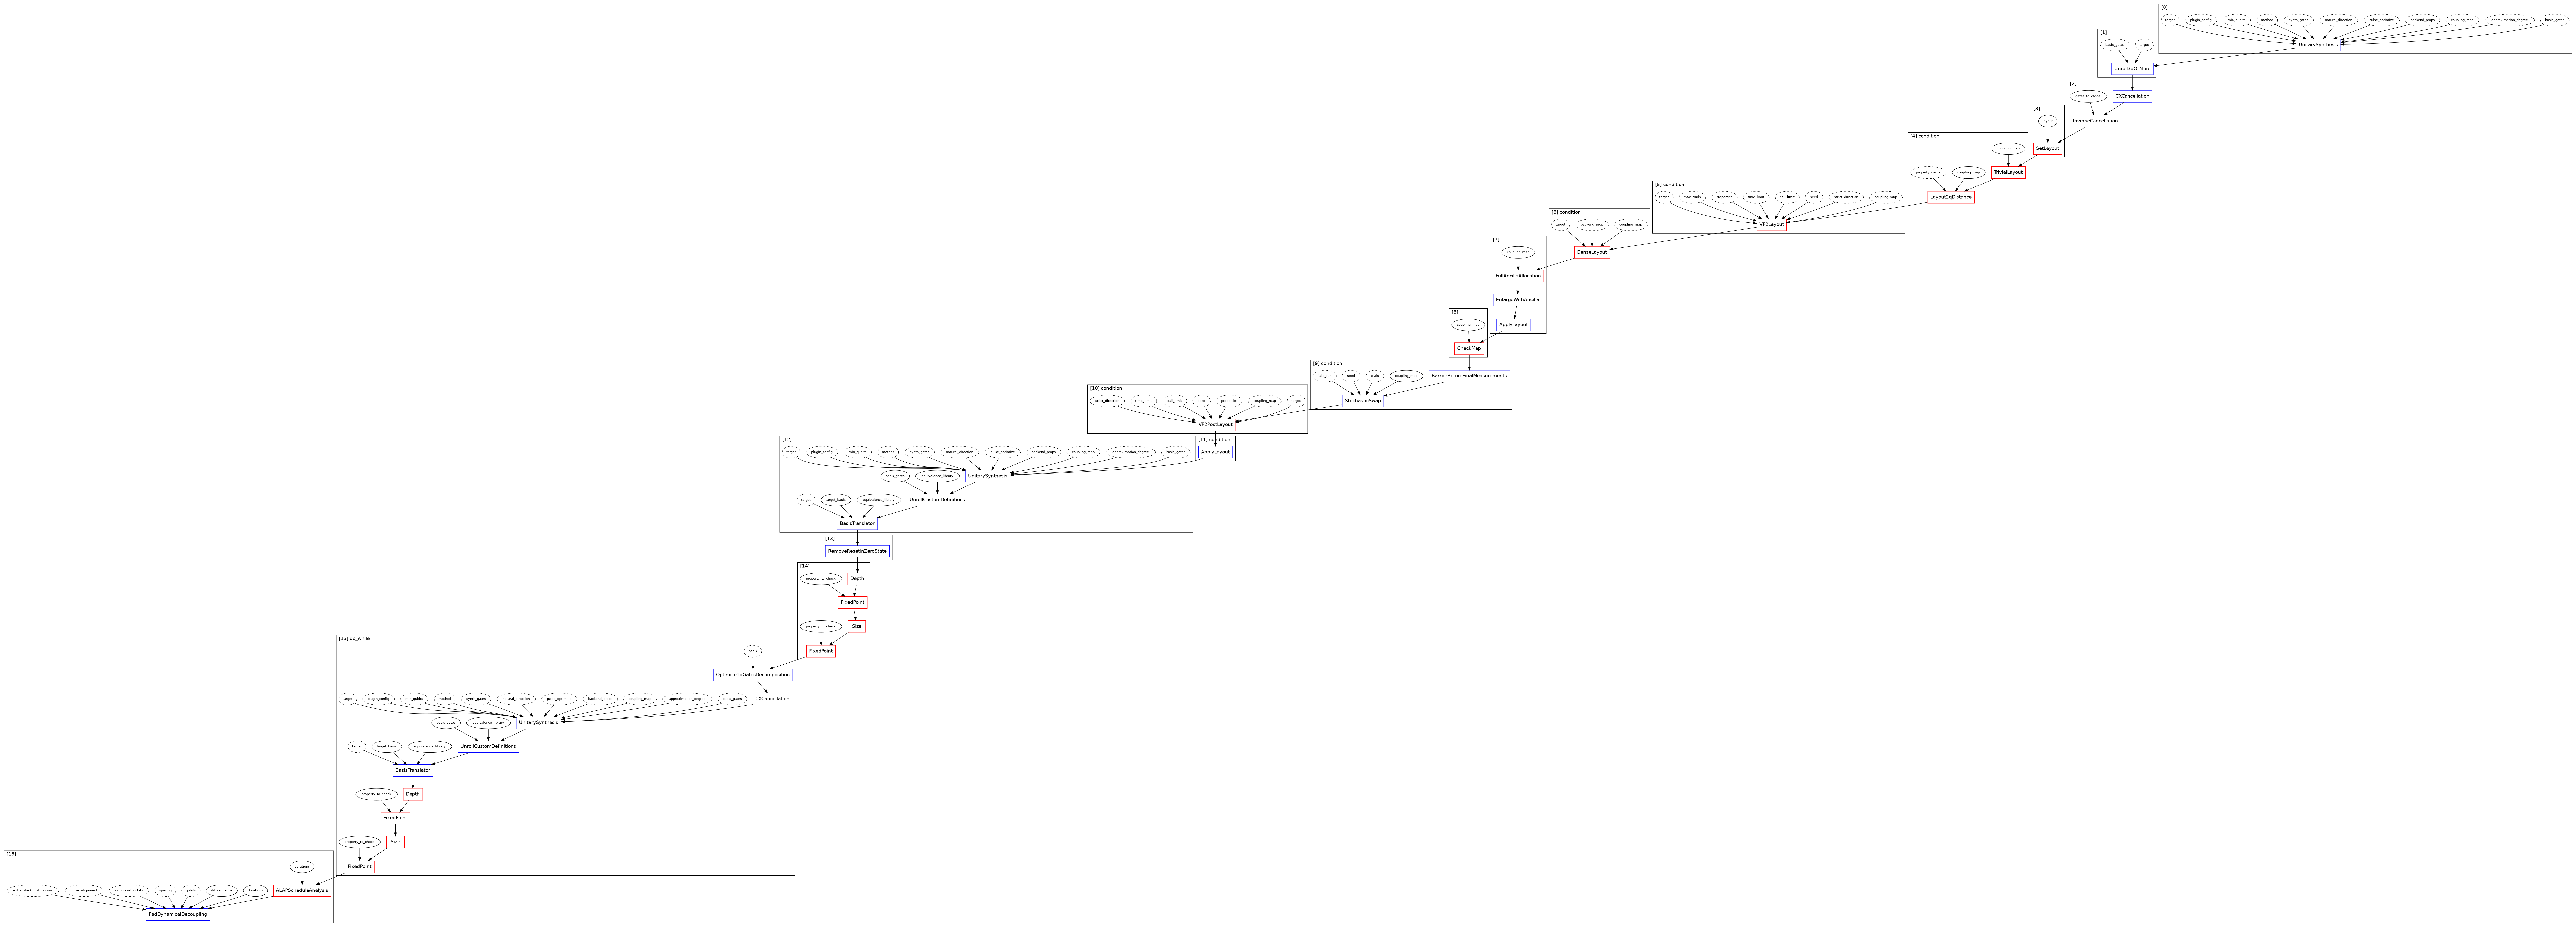

In [20]:
opt_level_1_pm.scheduling = scheduling_pm
opt_level_1_pm.pre_layout = logical_opt
opt_level_1_pm.draw()

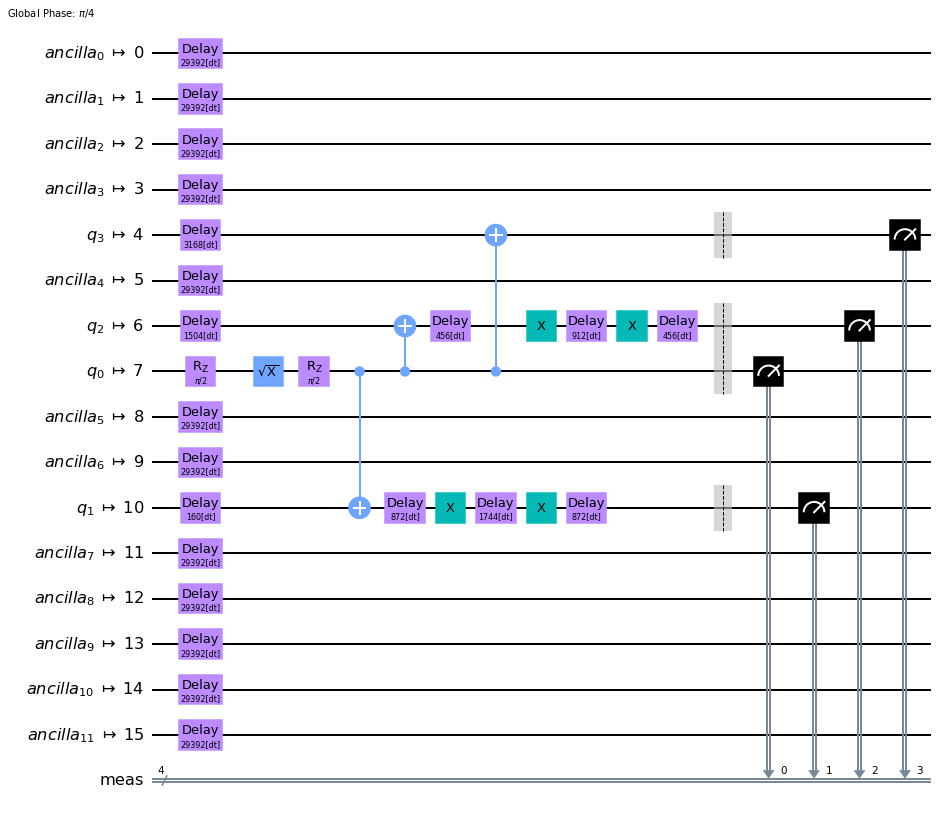

In [21]:
opt_level_1_pm.run(circuit).draw('mpl')

In [22]:
from qiskit.converters import dag_to_circuit
def callback(**kwargs):
    print(kwargs['pass_'])
    intermediate_circuit = dag_to_circuit(kwargs['dag'])
    intermediate_circuit.name = 'After:' +str(kwargs['pass_'])
    display(intermediate_circuit.draw('mpl'))

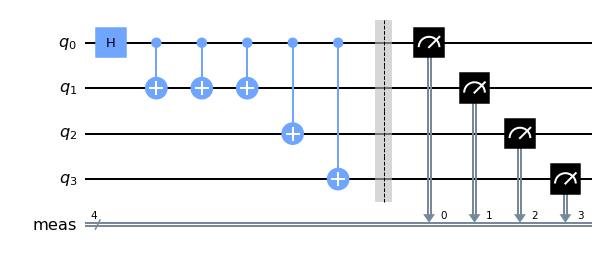

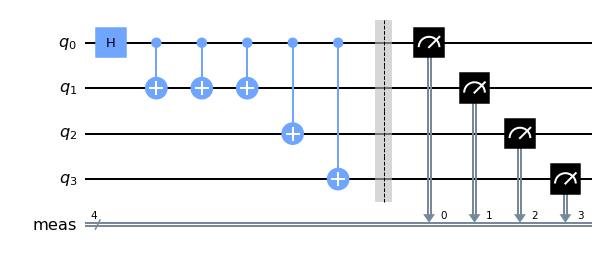

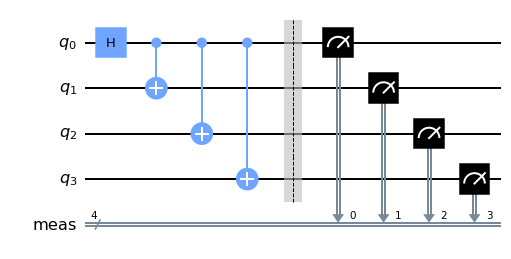

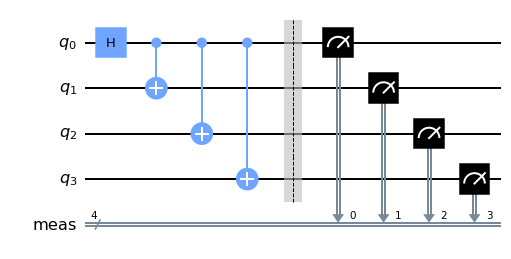

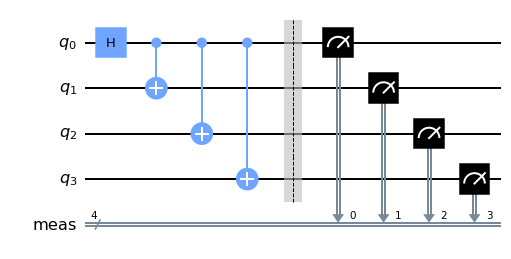

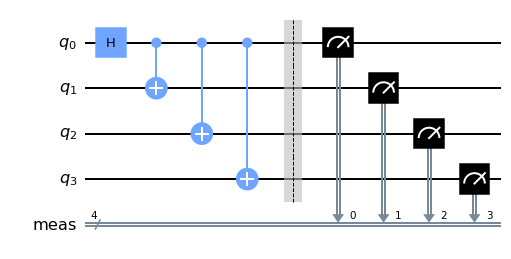

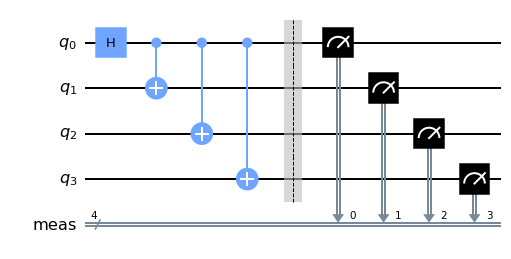

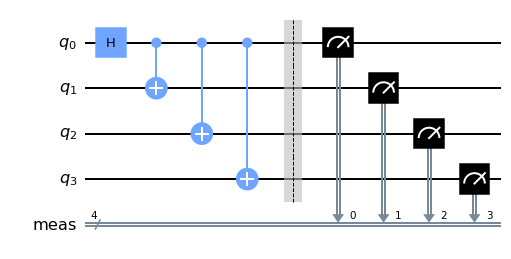

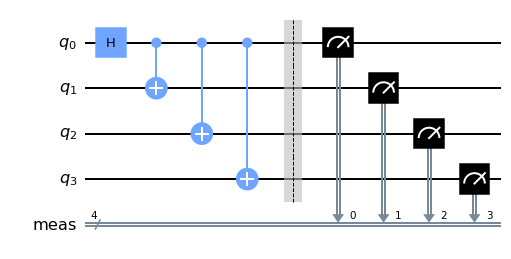

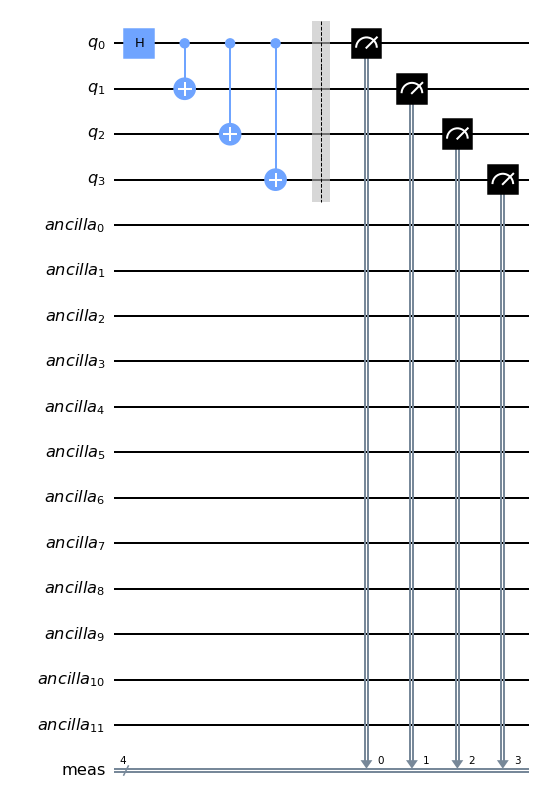

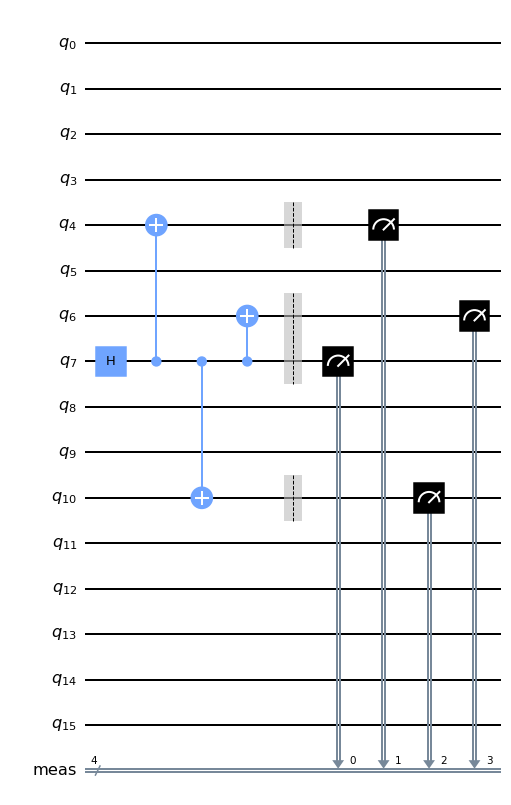

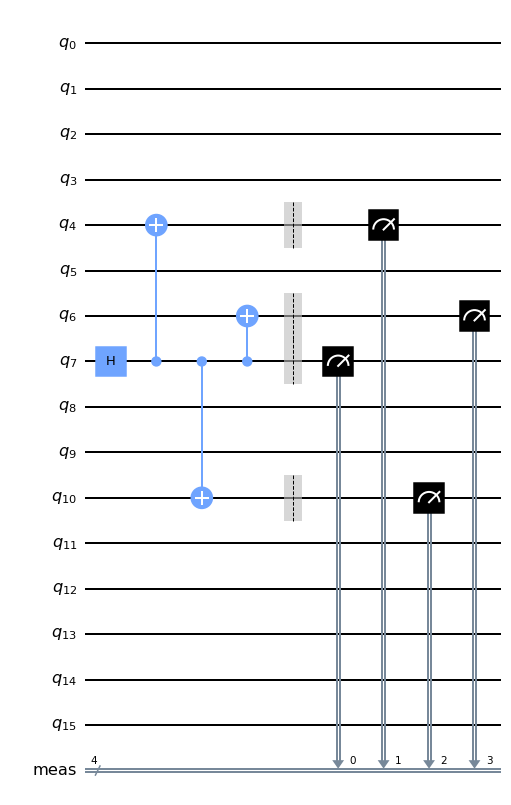

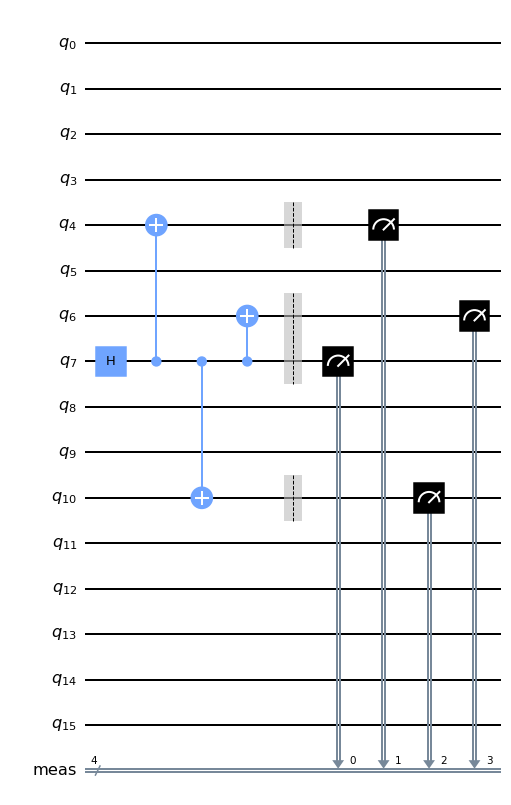

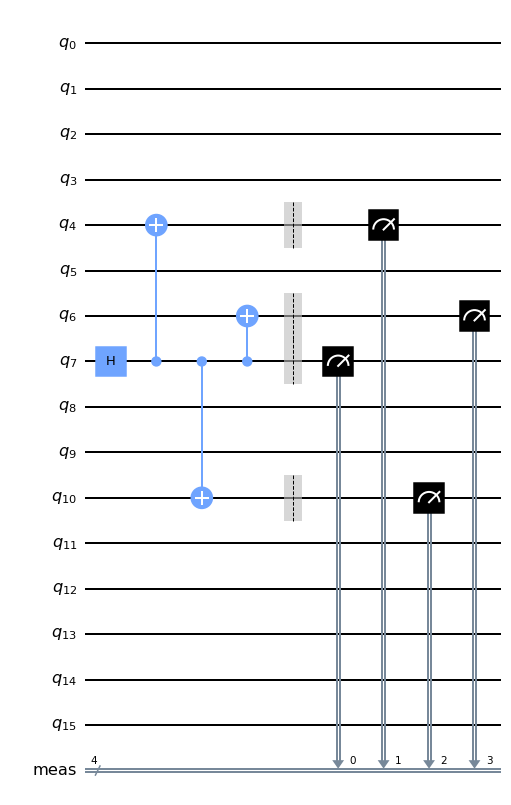

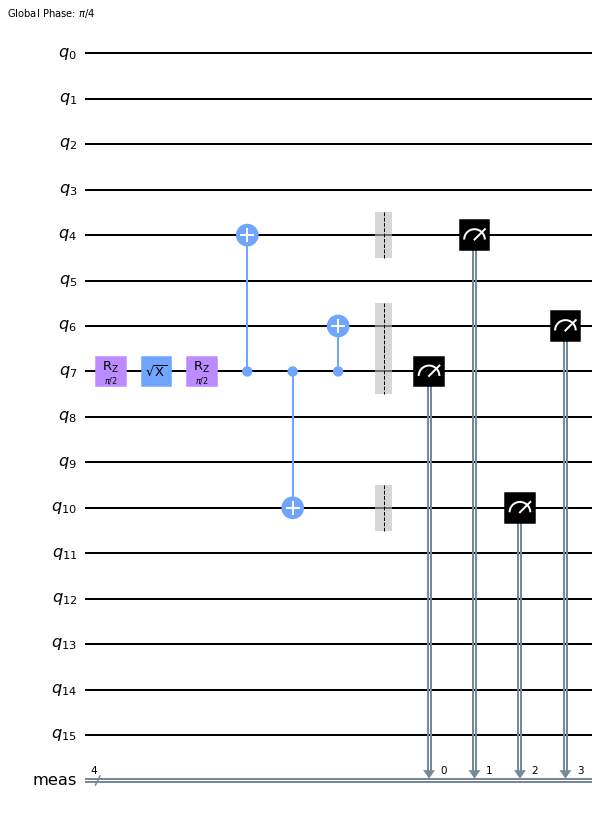

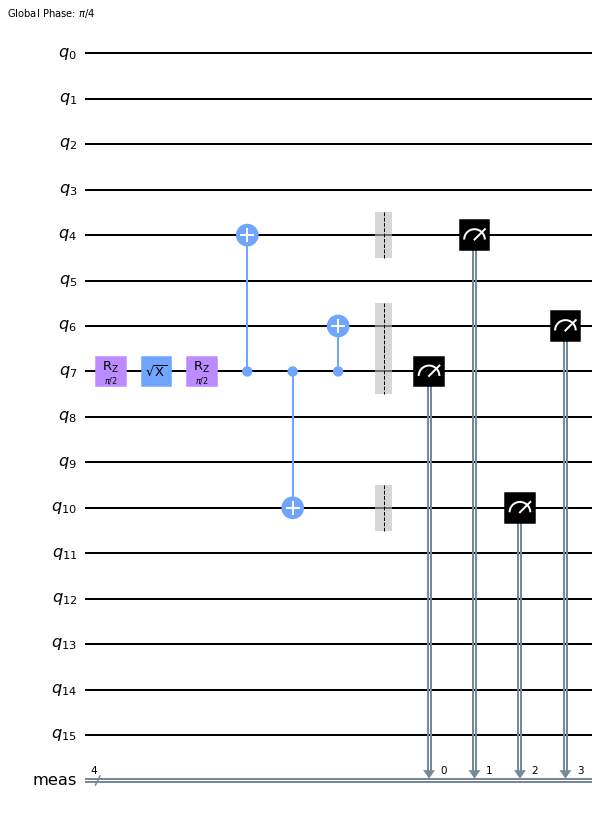

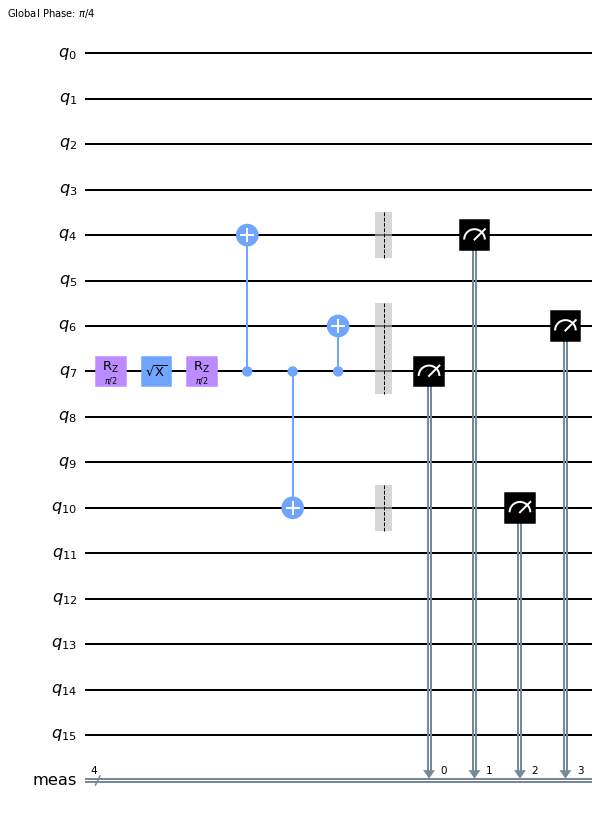

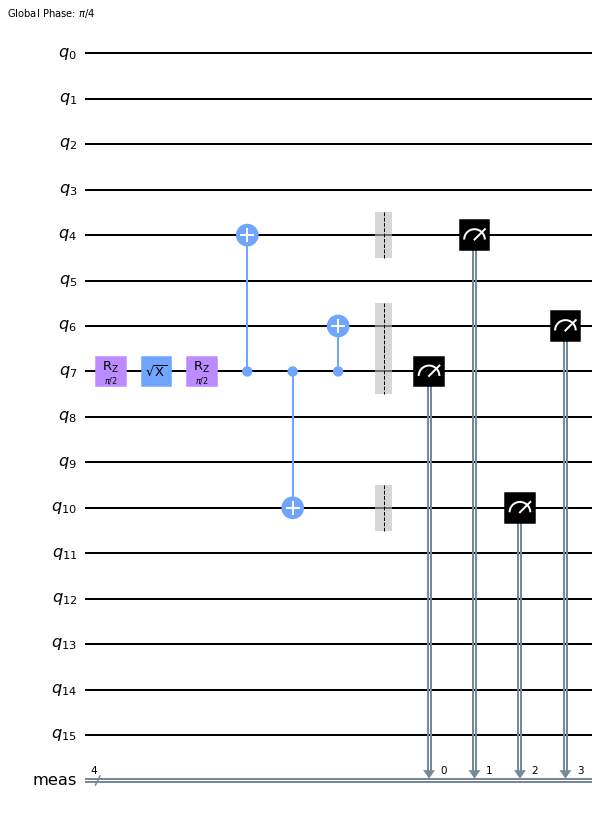

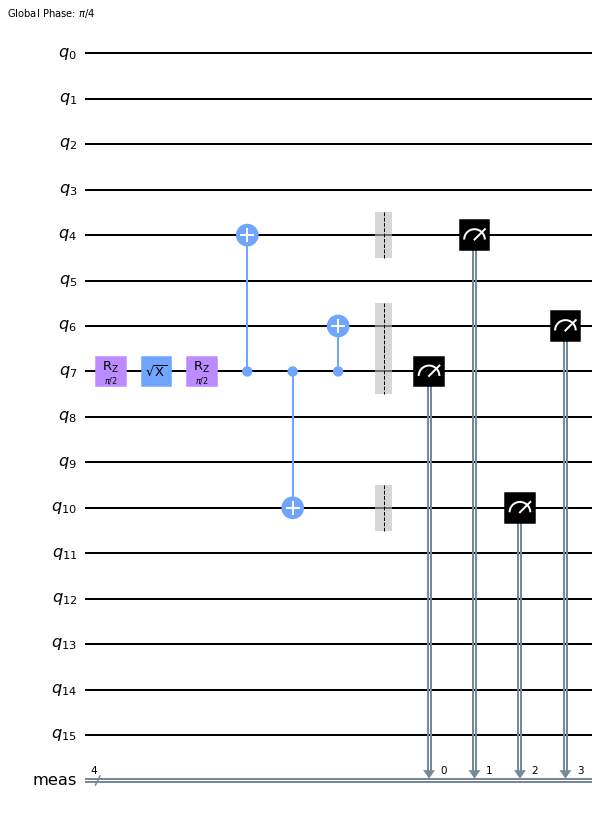

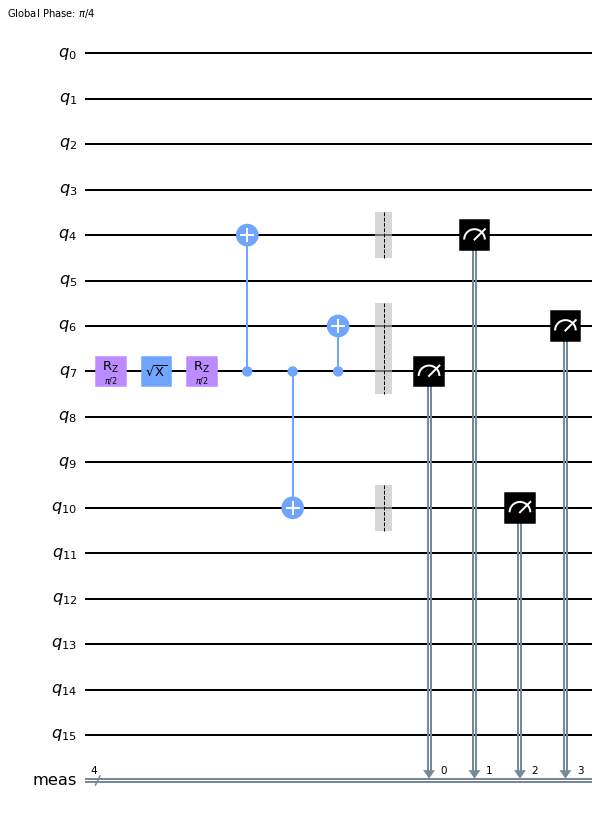

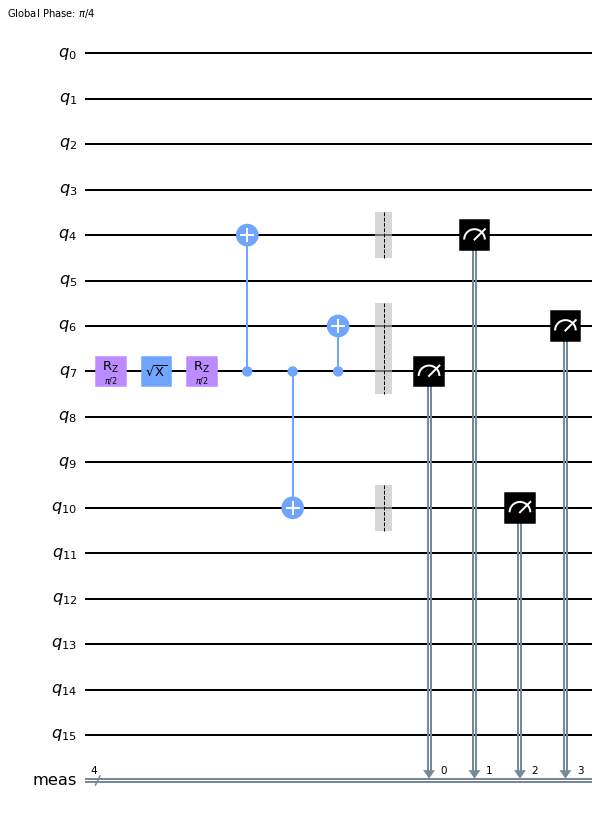

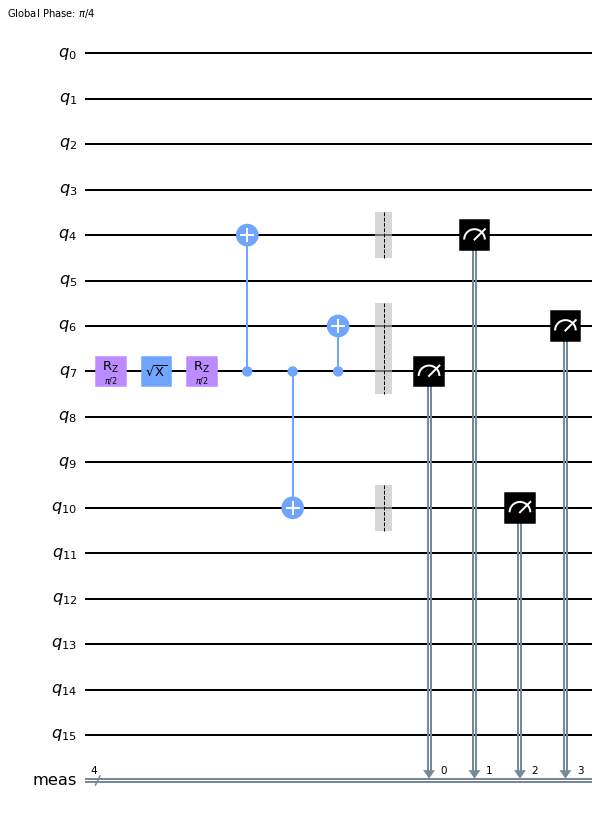

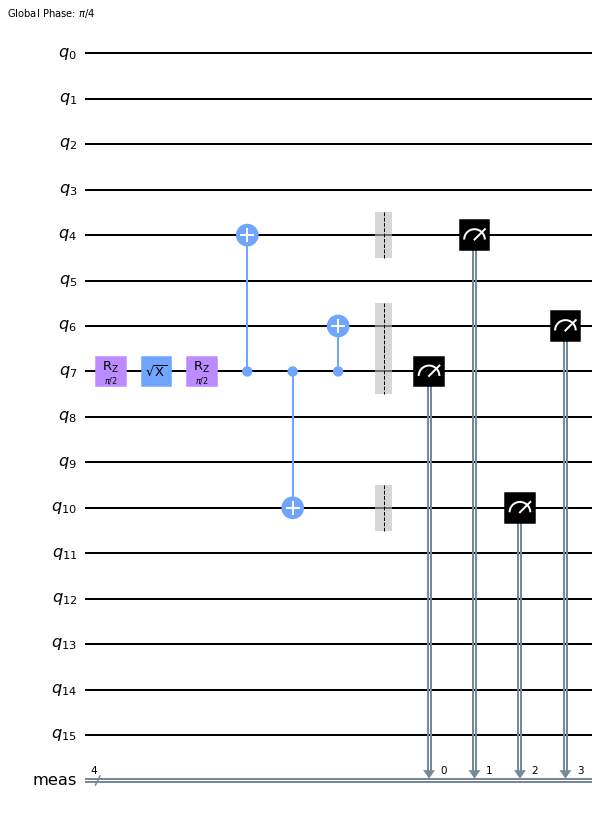

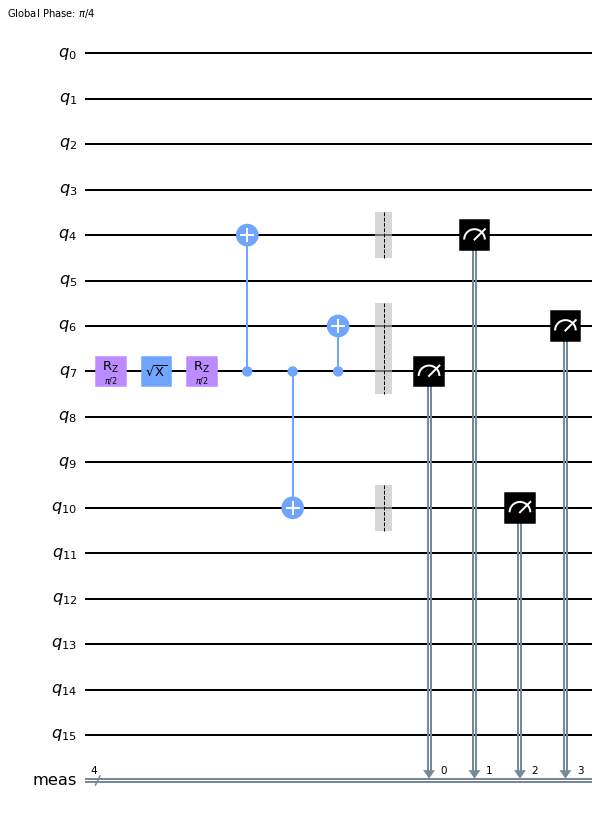

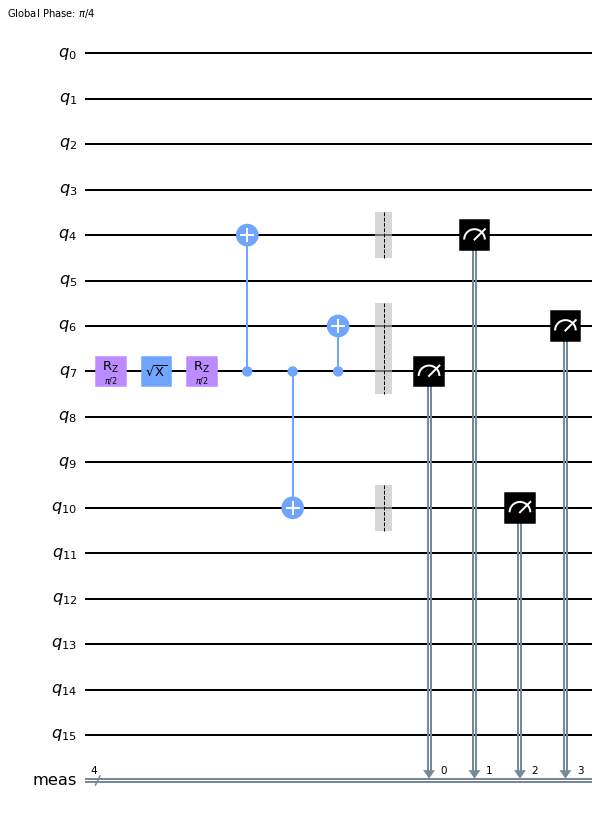

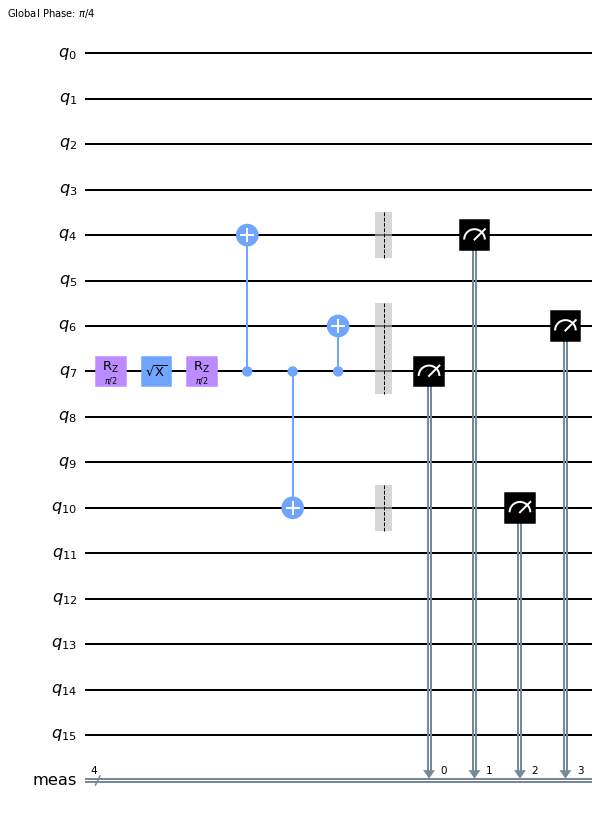

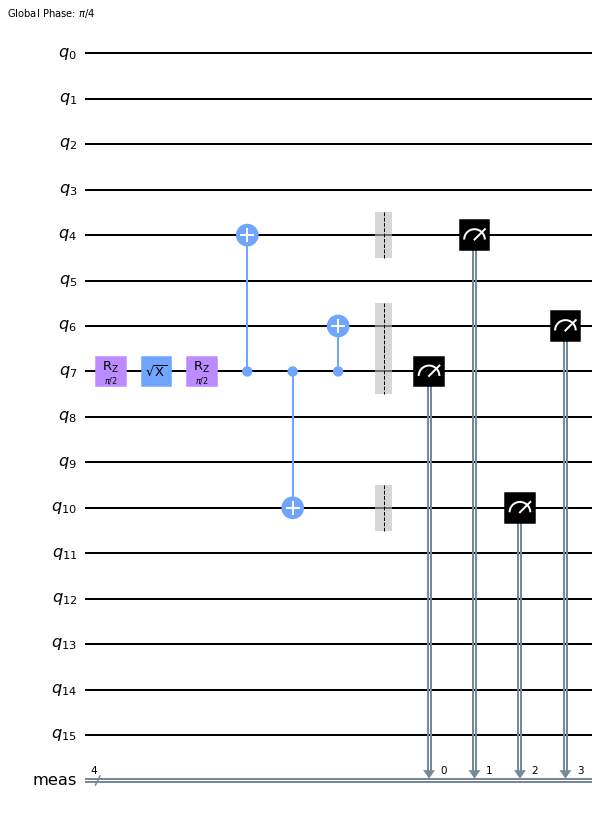

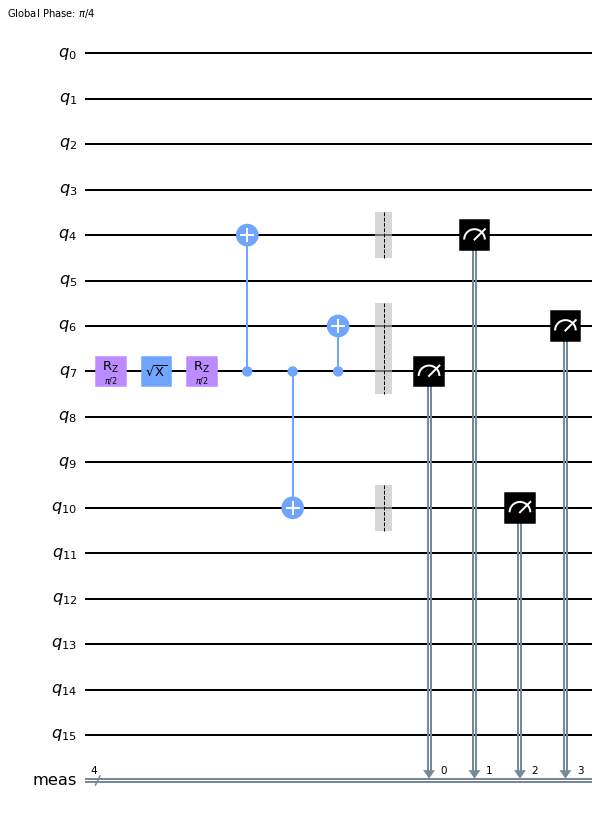

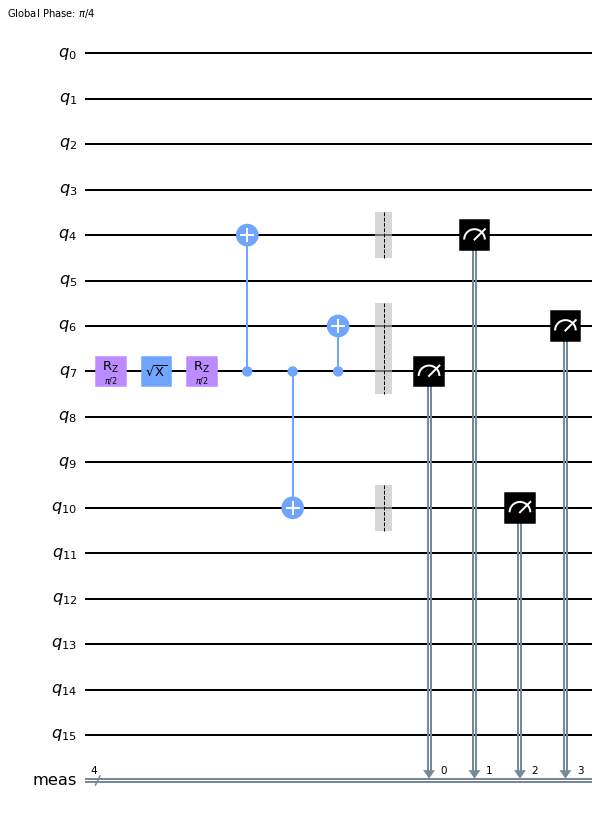

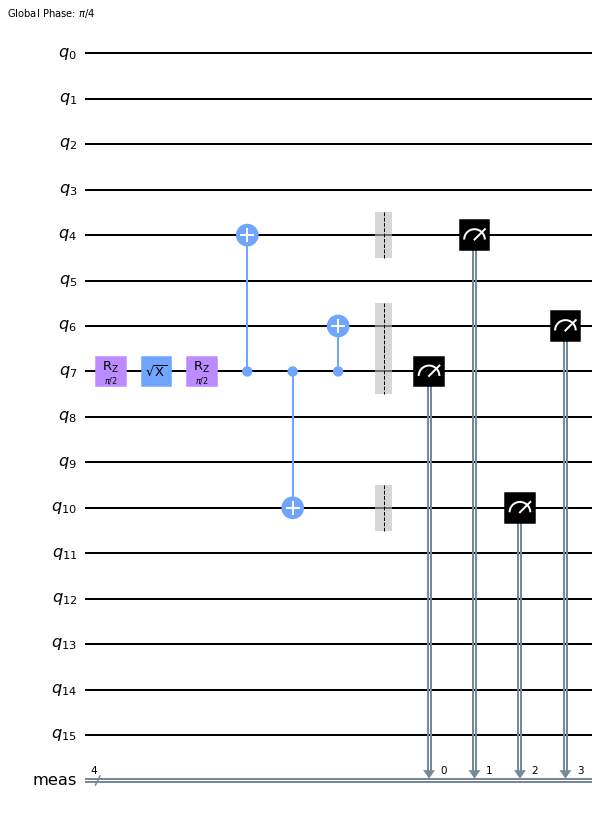

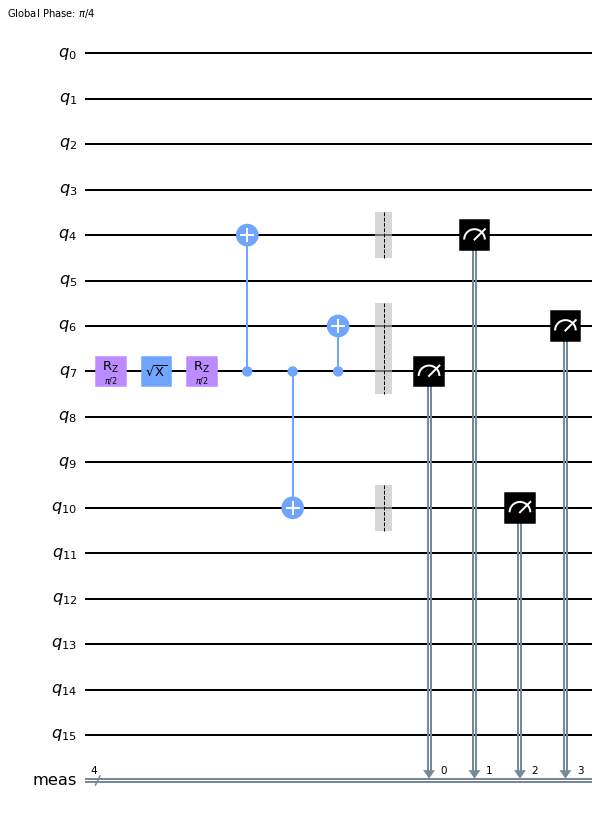

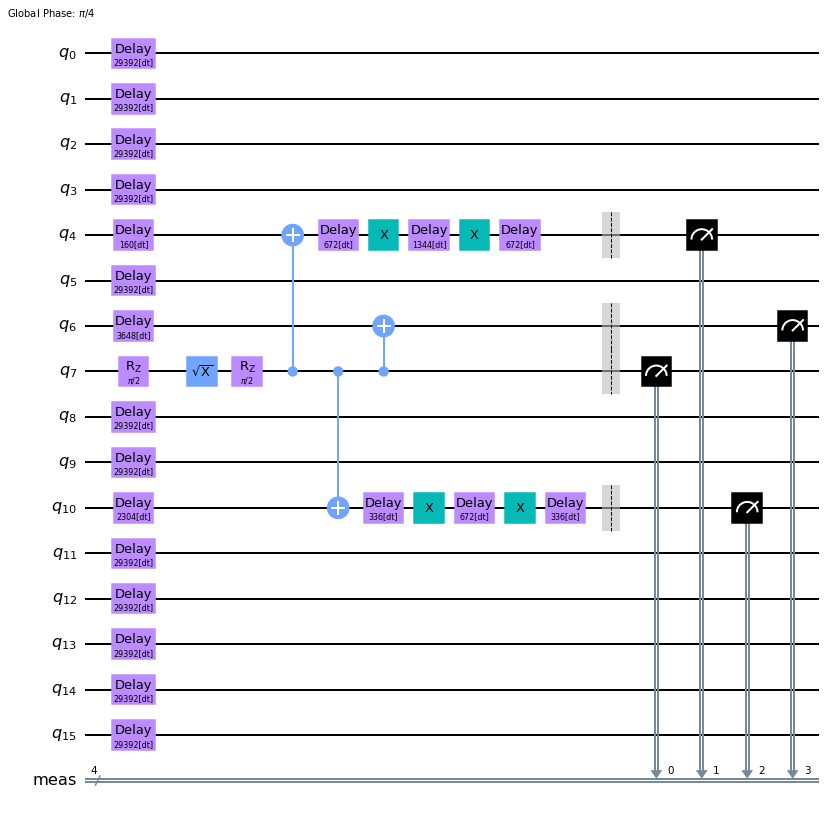

In [23]:
opt_level_1_pm.run(circuit, callback=callback)

## Future Work

- Adding plugin interface to `transpile()` to enable external stage implementations to be more easily integrated
- Updating `PassManager.draw()` method to show stages
- Adding hook points to `Backend` type objects for custom backend specific `PassManager`s to run on pre/post stages
    - This will enable things like custom optimization passes for custom basis gates on backends or DD to run automatically for backends